<img src="./Imagenes1/titulo.png" >

<img src="./Imagenes1/6.1.png" >

In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
import keras
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
data = pd.read_csv("Tasa_de_Cambio_Representativa_del_Mercado-_TRM.csv",sep= ',', decimal=",")
data.head()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
0,"2,850.98",COP,09/10/2002,09/10/2002
1,"2,854.04",COP,10/10/2002,10/10/2002
2,"2,870.63",COP,11/10/2002,11/10/2002
3,"2,861.16",COP,12/10/2002,15/10/2002
4,"2,852.99",COP,16/10/2002,16/10/2002


In [3]:
data.tail()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
6963,"3,763.82",COP,06/11/2020,06/11/2020
6964,"3,738.19",COP,07/11/2020,09/11/2020
6965,"3,646.15",COP,10/11/2020,10/11/2020
6966,"3,650.50",COP,11/11/2020,12/11/2020
6967,"3,646.22",COP,13/11/2020,13/11/2020


### Organizando la data:

In [4]:
# se deja la fecha vigenciadesde desde para que los viernes tengan esa TRM del viernes.
data.index = pd.to_datetime(data.VIGENCIADESDE) # volviendo el dato de fecha y dejandolo como el indice de la data
data.drop(['VIGENCIADESDE','VIGENCIAHASTA','UNIDAD'], axis = 'columns', inplace=True) #eliminando las variables no relevantes
data = data.sort_values(by=["VIGENCIADESDE"]) # ordenando las fechas
data = pd.DataFrame(data[data.index.is_month_end]) # filtrando la ultima fecha del mes 
data['VALOR'] = data['VALOR'].str.replace(",", "").astype(float) # para q pueda leer los numeros
data # tenemos datos mensuales.

,VALOR
VIGENCIADESDE,
1991-12-31,632.37
1992-01-31,644.27
1992-02-29,636.54
1992-03-31,641.59
1992-04-30,653.83
...,...
2020-03-31,4064.81
2020-04-30,3983.29
2020-07-31,3739.49


<img src="./Imagenes1/6.2.png" >    

* Separando la data sobre la que se identificara el modelo (Antes de 2018) : 
* Data de entrenamiento es data hasta 2017 :
* Data de prueba sera el 2018. 

<Figure size 720x432 with 0 Axes>

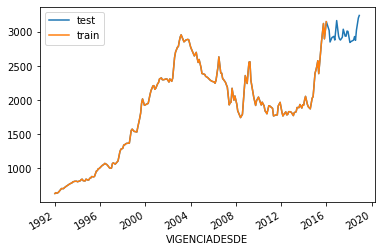

In [5]:
data_2018 = data[data.index.year <=  2018 ]
train = data[data.index.year <=  2015 ]
plt.figure(figsize=(10, 6))
ax = data_2018.plot()
train.plot(ax=ax)
plt.legend(['test', 'train']);
plt.show()

### Estandanrizando los datos para que la red neuronal tenga convergencia:

### Variables inputs de la red neuronal:

In [6]:
#Feature of Univariate time series is y_{t-1} to predict output y_{t}
trainS = preprocessing.scale(train.values.reshape(-1,1))
validationS = preprocessing.scale(data_2018.values.reshape(-1,1))

X1_train = trainS[2:-1] # y{t-1}
X2_train = trainS[1:-2] # y{t-2}
X3_train = trainS[0:-3] # y{t-3}

y_train = trainS[3:]
train_trm_1_2_3=np.concatenate((X1_train,X2_train,X3_train), axis=1)
test_trm_1_2_3=np.concatenate((validationS[2:-1],validationS[1:-2],validationS[0:-3]), axis=1)
#X_test = validationS[:-1]
y_test = validationS[3:]

In [7]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)


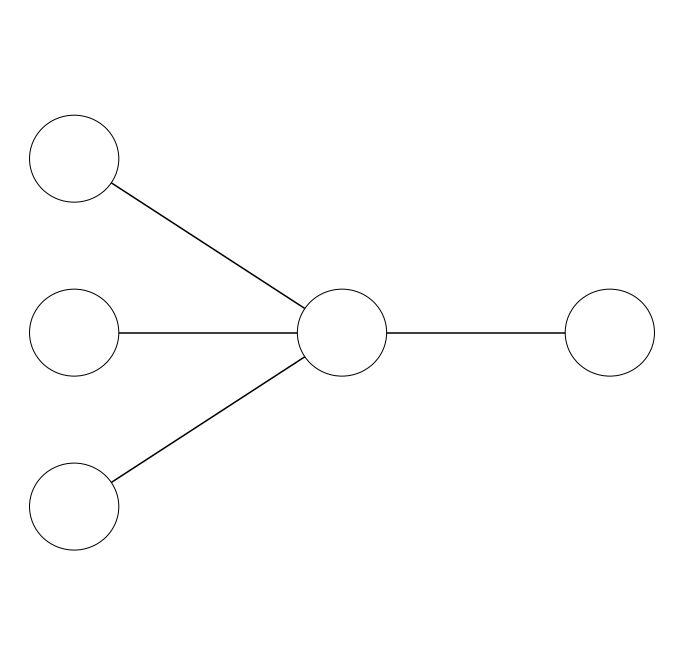

In [8]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [3,1, 1])
fig.savefig('nn.png')

In [9]:
tf.keras.backend.clear_session() 
tf.random.set_seed(51)
np.random.seed(51)

model = Sequential()
model.add(Dense(1, input_dim=3, activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse', optimizer = "adam")


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 4         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'EPOCHS ó CICLOS')

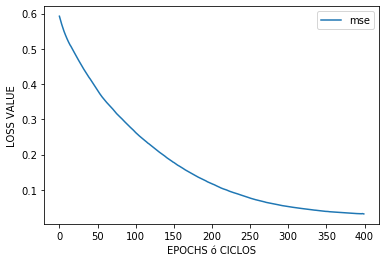

In [11]:
history = model.fit(train_trm_1_2_3, y_train,epochs =400, verbose=0)
plt.plot(range(400), history.history['loss'], label = 'mse') # conforme se repite el entrenamiento ent disminuye el error
plt.legend()
plt.ylabel("LOSS VALUE")
plt.xlabel("EPOCHS ó CICLOS")

In [12]:
print('Layer wights {}'.format(model.get_weights()))

Layer wights [array([[ 0.7493912 ],
       [-0.22080009],
       [ 0.17495786]], dtype=float32), array([0.9783395], dtype=float32), array([[1.4064943]], dtype=float32), array([-1.3444629], dtype=float32)]


In [13]:
forecast = model.predict(test_trm_1_2_3)
forecast_tr = forecast[ : train.shape[0]]  # train
forecast_te = forecast[ -(data_2018.shape[0] - train.shape[0]): ] # test

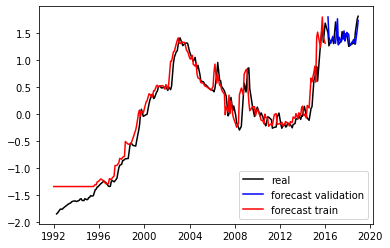

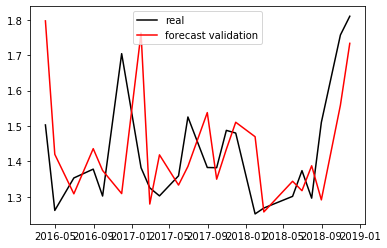

In [14]:
plt.plot(data_2018.index[3:],y_test, c = 'black', label = 'real')
plt.plot(data_2018.index[-(data_2018.shape[0] - train.shape[0]):],forecast_te, c = 'blue', label = 'forecast validation')
plt.plot(data_2018.index[:train.shape[0]],forecast_tr, c = 'red',label = 'forecast train')
plt.legend()
plt.plot()
plt.show()

plt.plot(data_2018.index[-(data_2018.shape[0] - train.shape[0]):],y_test[-(data_2018.shape[0] - train.shape[0]):], c = 'black', label = 'real')
plt.plot(data_2018.index[-(data_2018.shape[0] - train.shape[0]):],forecast_te, c = 'red', label = 'forecast validation')
plt.legend()
plt.plot()
plt.show()

In [15]:
print(' La correlacion en la fase de entrenamiento es: ',pd.DataFrame(forecast_tr,  columns = ['x']).x.corr(pd.DataFrame(y_test[:  train.shape[0]],  columns = ['x']).x))
print(' La correlacion en la fase de validacion es: ',pd.DataFrame(forecast_te,  columns = ['x']).x.corr(pd.DataFrame(y_test[-(data_2018.shape[0] - train.shape[0]):],  columns = ['x']).x))

 La correlacion en la fase de entrenamiento es:  0.9841272340424579
 La correlacion en la fase de validacion es:  0.3970340061428204


In [16]:
print(' El MAE es: ',mean_absolute_error(y_test[:  train.shape[0]],forecast_tr))
print(' El MAE es: ',mean_absolute_error(y_test[-(data_2018.shape[0] - train.shape[0]):],forecast_te))

 El MAE es:  0.12735050786927393
 El MAE es:  0.12661592437672356


### Red neuronal compleja :

In [17]:
def convertToMatrix(data, step): # es equivalente al codigo anterior pero automatizado
     X, Y =[], []
     for i in range(len(data)-step):
          d = i+step  
          X.append(data[i:d,])
          Y.append(data[d,])
     return np.array(X), np.array(Y)

lista = list(range(16))
lista

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [18]:
convertToMatrix(np.array(lista), 3) # matriz de inputs | vector de output

(array([[ 0,  1,  2],
        [ 1,  2,  3],
        [ 2,  3,  4],
        [ 3,  4,  5],
        [ 4,  5,  6],
        [ 5,  6,  7],
        [ 6,  7,  8],
        [ 7,  8,  9],
        [ 8,  9, 10],
        [ 9, 10, 11],
        [10, 11, 12],
        [11, 12, 13],
        [12, 13, 14]]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

In [19]:
train_trm_12 = []
test_trm_12 = []
for i in trainS:
    train_trm_12.append(i.mean())

for i in validationS:
    test_trm_12.append(i.mean())
train_trm_12, y_train  = convertToMatrix(np.array(train_trm_12), 12)
test_trm_12, y_test = convertToMatrix(np.array(test_trm_12), 12)

In [20]:
tf.keras.backend.clear_session() 
tf.random.set_seed(51)
np.random.seed(51)

model_1 = Sequential()
model_1.add(Dense(750, input_dim=12, activation='elu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(500, activation='elu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(250, activation='elu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(1,activation='linear'))
model_1.compile(loss='mse', optimizer = "adam")


In [21]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 750)               9750      
_________________________________________________________________
dropout (Dropout)            (None, 750)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               375500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

In [22]:
history = model_1.fit(train_trm_12, y_train,epochs =400, verbose=0)

Text(0.5, 0, 'EPOCHS ó CICLOS')

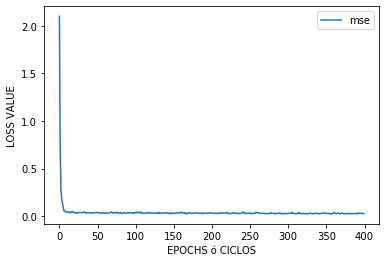

In [23]:
plt.plot(range(400), history.history['loss'], label = 'mse') # conforme se repite el entrenamiento ent disminuye el error
plt.legend()
plt.ylabel("LOSS VALUE")
plt.xlabel("EPOCHS ó CICLOS")

In [24]:
y_test = validationS[12:] # 12 neuronas de entrada ó rezago
forecast_12 = model_1.predict(test_trm_12)
forecast_tr_12 = forecast_12[ : -(data_2018.shape[0] - train.shape[0])]  # train
forecast_te_12 = forecast_12[ -(data_2018.shape[0] - train.shape[0]): ] # test

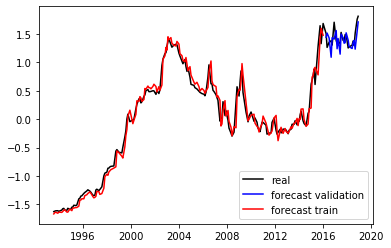

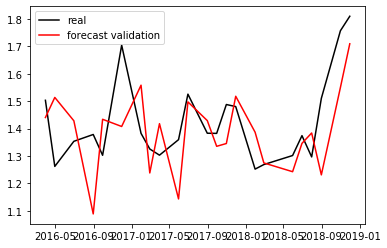

In [25]:
plt.plot(data_2018.index[12:],y_test, c = 'black', label = 'real')
plt.plot(data_2018.index[-(data_2018.shape[0] - train.shape[0]):],forecast_te_12, c = 'blue', label = 'forecast validation')
plt.plot(train.index[12:],forecast_tr_12, c = 'red',label = 'forecast train')
plt.legend()
plt.plot()
plt.show()

plt.plot(data_2018.index[-(data_2018.shape[0] - train.shape[0]):],y_test[-(data_2018.shape[0] - train.shape[0]):], c = 'black', label = 'real')
plt.plot(data_2018.index[-(data_2018.shape[0] - train.shape[0]):],forecast_te_12, c = 'red', label = 'forecast validation')
plt.legend()
plt.plot()
plt.show()

In [26]:
print(' La correlacion en la fase de entrenamiento es: ',pd.DataFrame(forecast_tr_12,  columns = ['x']).x.corr(pd.DataFrame(y_test[:  train.shape[0]],  columns = ['x']).x))
print(' La correlacion en la fase de validacion es: ',pd.DataFrame(forecast_te_12,  columns = ['x']).x.corr(pd.DataFrame(y_test[-(data_2018.shape[0] - train.shape[0]):],  columns = ['x']).x))

 La correlacion en la fase de entrenamiento es:  0.990056481420554
 La correlacion en la fase de validacion es:  0.4738164997815194


In [27]:
print(' El MAE de entrenamiento es: ',mean_absolute_error(y_test[12:  train.shape[0]],forecast_tr_12))
print(' El MAE de validacion es: ',mean_absolute_error(y_test[-(data_2018.shape[0] - train.shape[0]):],forecast_te_12))

 El MAE de entrenamiento es:  0.4675583106750303
 El MAE de validacion es:  0.12631845162405694


<img src="./Imagenes1/6.3.png" >

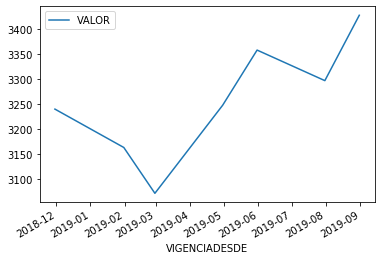

In [28]:
sept_2019 = datetime(2019,10,1)  # un dia despues al ultimo dia del mes de septiembre (para incluir septiembre).
test = data[data.index < sept_2019]
test.tail(7).plot()

### Ajustando los inputs para los 2 modelos de redes neuronales en la fase de prueba:

In [29]:
# Ajuste de inputs para modelo simple:
testS = preprocessing.scale(test.values.reshape(-1,1))


X1_test = testS[2:-1] # y{t-1}
X2_test = testS[1:-2] # y{t-2}
X3_test = testS[0:-3] # y{t-3}

y_test = testS[3:]
test_trm_3=np.concatenate((X1_test,X2_test,X3_test), axis=1)

In [30]:
# Ajuste de inputs para modelo complejo:
testeo = []
for i in testS:
    testeo.append(i.mean())

    
test_trm_12, y_test1  = convertToMatrix(np.array(testeo), 12)

In [31]:
forecast_test_3 = model.predict(test_trm_3) # pronostico modelo 1 ( red simple)
forecast_test_12 = model_1.predict(test_trm_12) # pronostico modelo 2 ( red compleja)

In [32]:
forecast_test_3 = forecast_test_3[-9:] # los ultimos 9 meses de la data = enero y sep de 2019
forecast_test_12 = forecast_test_12[-9:] # los ultimos 9 meses de la data = enero y sep de 2019
y_real = testeo[-9:] # dato real

### Proceso inverso a la estandarizacion:

In [33]:
def des_estandarizacion(data, mu, std):
    forecast = []
    for i in range(len(data)):
        forecast.append(float(data[i])* std + mu)
    return(forecast)

forecast_3 = des_estandarizacion(forecast_test_3, test.values.mean(),test.values.std())
forecast_12 = des_estandarizacion(forecast_test_12, test.values.mean(),test.values.std()) 

In [34]:
def RMSE(real, forecast):
    metrica = 0
    for i in range(len(real)):
        metrica = metrica + (real[i] - forecast[i])**2 
    metrica = metrica/len(real)
    metrica = np.sqrt(metrica)
    
    return(round(metrica,5))

def MAE(real, forecast):
    metrica = 0
    for i in range(len(real)):
        metrica = metrica + np.abs(real[i] - forecast[i])
    metrica = metrica/len(real)   
    return(round(metrica,5))

In [35]:
print('El RMSE de la red neuronal sencilla: ',RMSE(test.VALOR.values[-9:], forecast_3))
print('El RMSE de la red compleja: ',RMSE(test.VALOR.values[-9:], forecast_12))

El RMSE de la red neuronal sencilla:  109.21158
El RMSE de la red compleja:  116.62181


In [36]:
print(' El MAE de la red sencilla: ',mean_absolute_error(test.VALOR.values[-9:],forecast_3))
print(' El MAE de la red compleja: ',mean_absolute_error(test.VALOR.values[-9:],forecast_12))

 El MAE de la red sencilla:  98.19606386015296
 El MAE de la red compleja:  102.22167026021735


In [37]:
print(' La correlacion de la red sencilla es: ',pd.DataFrame(forecast_3,  columns = ['x']).x.corr(pd.DataFrame(np.array(test.VALOR.values[-9:]),  columns = ['x']).x))
print(' La correlacion de la red compleja es: ',pd.DataFrame(forecast_12,  columns = ['x']).x.corr(pd.DataFrame(np.array(test.VALOR.values[-9:]),  columns = ['x']).x))

 La correlacion de la red sencilla es:  0.7478311789784428
 La correlacion de la red compleja es:  0.7621214005592208


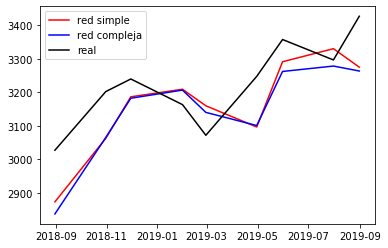

In [38]:
plt.plot(test.index[-9:],forecast_3,label ='red simple', c='red')
plt.plot(test.index[-9:],forecast_12, label ='red compleja',c='blue')
plt.plot(test.index[-9:],test.VALOR.values[-9:],label ='real',c='black' )
plt.legend()
plt.show()

<img src="./Imagenes1/6.4.png" >

In [39]:
train = data[data.index.year <=  2018 ]  
train = train.diff().dropna()

### Modelo 1:

In [40]:
information_criterion='aic'

In [41]:
modelo1 = pm.auto_arima(train, 
                      # la serie es ciclica:
                      seasonal=False, m=0, # no tiene ciclo la serie 
                      # sabemos por dicky fuller que:
                      d=0, D=0, # No diferencio el arima (d=9)  y diferencio el Sarima (D=1)!
                      # loop del arima(p,0,q):
                      start_p = 0, start_q=0,
                      max_p=12, max_q=12,
                      trace=True, # imprima el loop
                      information_criterion = information_criterion, # le creo mas al bic que al aic
                      error_action='ignore', # si no se pudo correr un modelo siga
                      stepwise = True, # haga el loop inteligentemente
                      suppress_warnings=True) 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2633.208, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2634.539, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2631.642, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2633.638, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2633.639, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2636.224, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2636.405, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2634.616, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2630.573, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2633.597, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2633.631, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2632.552, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2632.553, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : A

In [42]:
print(modelo1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  219
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1311.287
Date:                Sun, 06 Dec 2020   AIC                           2630.573
Time:                        17:33:14   BIC                           2644.130
Sample:                             0   HQIC                          2636.048
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.4616     13.535      1.660      0.097      -4.066      48.989
ar.L1         -0.8884      0.072    -12.418      0.000      -1.029      -0.748
ma.L1          0.9615      0.050     19.399      0.0

### Modelo 2:
* MA(1)

In [43]:
modelo2 = SARIMAX(train, order = (0,0,1)).fit()

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Modelo3:
* AR(2)

In [44]:
modelo3 = SARIMAX(train, order = (2,0,0)).fit()

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### Creando la función para hacer la rolling window para los modelos ARMA:

In [45]:
def rolling_window(p,q, data,n_ahead,step):
    predict = []
    lower_limits = []
    upper_limits = []
    for i in range(n_ahead):
        rolling_data = data.iloc[i:data.shape[0] + i - n_ahead] # data para entrenar el modelo
        modelito = SARIMAX(rolling_data, order = (p,1,q)).fit() # fiteando
        dia_adelante = modelito.get_forecast(steps=step) # pronosticando de mes a mes 
        predict.append(float(dia_adelante.predicted_mean) ) # guardando el pronostico medio
        
        # intervalo de confianza 
        confidence_intervals = dia_adelante.conf_int()
        # guardando el intervalo de confianza bajo y max
        lower_limits.append(float(confidence_intervals.loc[:,'lower VALOR']))
        upper_limits.append(float(confidence_intervals.loc[:,'upper VALOR']))
    return(predict,lower_limits , upper_limits)


### Realizando la rolling window para:
* El modelo 1 : ARMA(1,1)
* El modelo 2 : MA(1)
* El modelo 3 : AR(2)

In [46]:
# arma(1,1):
arma_predict, arma_lw_limits, arma_up_limits = rolling_window(p = 1,q = 1, data = test,n_ahead = 9 ,step = 1)

# ma(1):
ma_predict, ma_lw_limits, ma_up_limits = rolling_window(p = 0,q = 1, data = test,n_ahead = 9 ,step = 1)

# ar(2):
ar_predict, ar_lw_limits, ar_up_limits = rolling_window(p = 2,q = 0, data = test,n_ahead = 9 ,step = 1)

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters 

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with

C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Oscar .LAPTOP-UUDRGSUV\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency inf

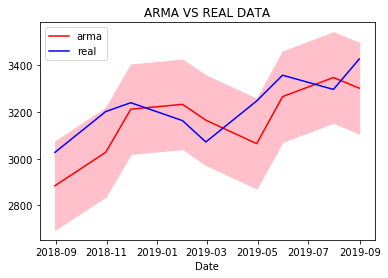

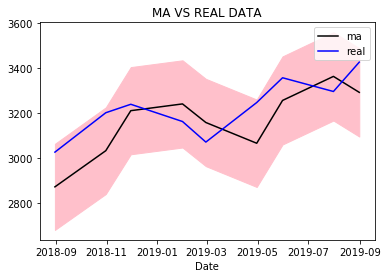

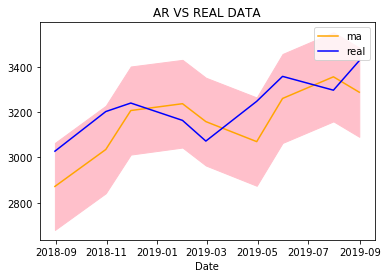

In [47]:
plt.plot(test.tail(9).index,arma_predict, label = 'arma', c='r')
plt.plot(test.tail(9), label = 'real', c= 'b')
plt.fill_between(test.tail(9).index,arma_lw_limits, arma_up_limits, color='pink')
plt.xlabel('Date')
plt.title('ARMA VS REAL DATA')
plt.legend()
plt.show()

plt.plot(test.tail(9).index,ma_predict, label = 'ma', c='black')
plt.plot(test.tail(9), label = 'real', c= 'b')
plt.fill_between(test.tail(9).index,ma_lw_limits, ma_up_limits, color='pink')
plt.xlabel('Date')
plt.title('MA VS REAL DATA')
plt.legend()
plt.show()

plt.plot(test.tail(9).index,ar_predict, label = 'ma', c='orange')
plt.plot(test.tail(9), label = 'real', c= 'b')
plt.fill_between(test.tail(9).index,ar_lw_limits, ar_up_limits, color='pink')
plt.xlabel('Date')
plt.title('AR VS REAL DATA')
plt.legend()
plt.show()

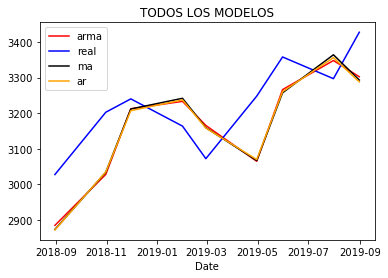

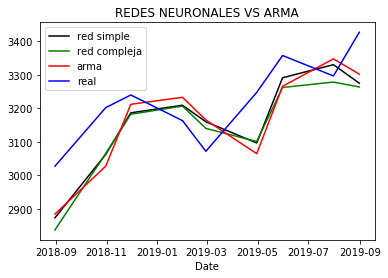

In [48]:
plt.plot(test.tail(9).index,arma_predict, label = 'arma', c='red')
plt.plot(test.tail(9), label = 'real', c= 'blue')
plt.plot(test.tail(9).index,ma_predict, label = 'ma', c='black')
plt.plot(test.tail(9).index,ar_predict, label = 'ar', c='orange')
plt.xlabel('Date')
plt.title('TODOS LOS MODELOS')
plt.legend()
plt.show()

plt.plot(test.index[-9:],forecast_3,label ='red simple', c='black')
plt.plot(test.index[-9:],forecast_12, label ='red compleja',c='green')
plt.plot(test.tail(9).index,arma_predict, label = 'arma', c='red')
plt.plot(test.tail(9), label = 'real', c= 'blue')
plt.xlabel('Date')
plt.title('REDES NEURONALES VS ARMA')
plt.legend()
plt.show()

### Test de Diabold - Mariano:

In [49]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [50]:
print('EL RMSE DEL ARMA: ',RMSE(test.tail(9)['VALOR'].tolist(),arma_predict))
print('EL RMSE DEL MA : ',RMSE(test.tail(9)['VALOR'].tolist(),ma_predict))
print('EL RMSE DEL AR : ',RMSE(test.tail(9)['VALOR'].tolist(),ar_predict))
print('EL RMSE DE LA RED NEURONAL SIMPLE : ',RMSE(test.tail(9)['VALOR'].tolist(),forecast_3))
print('EL RMSE DEL LA RED NEURONAL COMPLEJA : ',RMSE(test.tail(9)['VALOR'].tolist(),forecast_12))

EL RMSE DEL ARMA:  118.01692
EL RMSE DEL MA :  121.18605
EL RMSE DEL AR :  120.37145
EL RMSE DE LA RED NEURONAL SIMPLE :  109.21158
EL RMSE DEL LA RED NEURONAL COMPLEJA :  116.62181


In [51]:
print('EL MAE DEL ARMA: ',MAE(test.tail(9)['VALOR'].tolist(),arma_predict))
print('EL MAE DEL MA : ',MAE(test.tail(9)['VALOR'].tolist(),ma_predict))
print('EL MAE DEL AR : ',MAE(test.tail(9)['VALOR'].tolist(),ar_predict))
print('EL MAE DE LA RED NEURONAL SIMPLE : ',MAE(test.tail(9)['VALOR'].tolist(),forecast_3))
print('EL MAE DEL LA RED NEURONAL COMPLEJA : ',MAE(test.tail(9)['VALOR'].tolist(),forecast_12))

EL MAE DEL ARMA:  106.54576
EL MAE DEL MA :  111.07197
EL MAE DEL AR :  110.01419
EL MAE DE LA RED NEURONAL SIMPLE :  98.19606
EL MAE DEL LA RED NEURONAL COMPLEJA :  102.22167


In [52]:
print('LA CORR DEL ARMA: ',pd.DataFrame(arma_predict,  columns = ['x']).x.corr(pd.DataFrame(np.array(test.VALOR.values[-9:]),  columns = ['x']).x))
print('LA CORR DEL MA: ',pd.DataFrame(ma_predict,  columns = ['x']).x.corr(pd.DataFrame(np.array(test.VALOR.values[-9:]),  columns = ['x']).x))
print('LA CORR DEL AR: ',pd.DataFrame(ar_predict,  columns = ['x']).x.corr(pd.DataFrame(np.array(test.VALOR.values[-9:]),  columns = ['x']).x))
print('LA CORR DE LA RED NEURONAL SIMPLE: ',pd.DataFrame(forecast_3,  columns = ['x']).x.corr(pd.DataFrame(np.array(test.VALOR.values[-9:]),  columns = ['x']).x))
print('LA CORR DE LA RED NEURONAL COMPLEJA: ',pd.DataFrame(forecast_12,  columns = ['x']).x.corr(pd.DataFrame(np.array(test.VALOR.values[-9:]),  columns = ['x']).x))

LA CORR DEL ARMA:  0.7025341272946255
LA CORR DEL MA:  0.6921268917687083
LA CORR DEL AR:  0.6982004894659529
LA CORR DE LA RED NEURONAL SIMPLE:  0.7478311789784428
LA CORR DE LA RED NEURONAL COMPLEJA:  0.7621214005592208


##### Test entre modelo ARMA y la Red Neuronal Simple:

In [53]:
dm_test(test.tail(9)['VALOR'].tolist(), arma_predict, forecast_3, h = 1, crit="MSE", power = 2) 
# p- value > 5% entonces no rechazo la hipotesis nula y soy indiferente a cualquier pronostico.

dm_return(DM=0.9836484010871153, p_value=0.35409793045133164)

###### Test entre modelo ARMA y la y Red Neuronal Compleja:

In [54]:
dm_test(test.tail(9)['VALOR'].tolist(), arma_predict, forecast_12, h = 1, crit="MSE", power = 2) 
# p- value > 5% entonces NO rechazo la hipotesis nula y los modelos pronostican de forma similar 

dm_return(DM=0.10591549554345937, p_value=0.918257064383107)

###### Test entre modelo MA y la y Red Neuronal Simple:

In [55]:
dm_test(test.tail(9)['VALOR'].tolist(), ma_predict, forecast_3, h = 1, crit="MSE", power = 2) 
# p- value > 5% entonces NO rechazo la hipotesis nula y los modelos son indiferentes en el error

dm_return(DM=1.6505892526195745, p_value=0.13742917966578164)

###### Test entre modelo MA y la y Red Neuronal Compleja:

In [56]:
dm_test(test.tail(9)['VALOR'].tolist(), ma_predict, forecast_12, h = 1, crit="MSE", power = 2) 
# p- value > 5% entonces NO rechazo la hipotesis nula y los modelos son indiferentes en el error

dm_return(DM=0.41714614783199017, p_value=0.6875406690673307)

<img src="./Imagenes/4.0 .PNG" >  

In [ ]:
data = pd.read_csv("OxfordManRealizedVolatilityIndices.csv",sep=",",parse_dates=[0],index_col=[0])
data

In [ ]:
print(data.columns)

El indice seleccionado es HSI ó HANG SENG Index porque me gustaria analizar el desempeño de 33 compañias mas importantes Hong Kong.

In [ ]:
data = data[data["Symbol"] == ".HSI"]
data

In [ ]:
ret=np.log(data.close_price).diff(periods=1)*100  # calculo de los retornos.
fig, ax1 = plt.subplots()
ax1.set_xlabel('date')
ax1.set_ylabel('Indice', color='blue')
ax1.plot(data.index[1:4350], data.close_price[1:4350], color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()  
ax2.set_ylabel('Retornos Diarios', color='red')  
ax2.plot(data.index[1:4591],ret.values[1:4591], color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout() 
plt.show()

Cuando cae el mercado se evidencia una alta volatilidad y cuando el indice esta al alza a volatilidad disminuye.

<img src="./Imagenes/4.1 .png" >  

In [ ]:
print(data.index[4412] )

retornos_2017 = ret[1:4413]
retornos_2017

In [ ]:
basic_garch = arch_model(retornos_2017,p = 1, q = 1, vol = 'GARCH', dist = 'normal', mean = 'Zero')
basic_garch_fit = basic_garch.fit()
print(basic_garch_fit.summary())

<img src="./Imagenes/garch.png" > 

In [ ]:
residuals = basic_garch_fit.resid # retornos ó el residuo de modelo 
std = basic_garch_fit.conditional_volatility # volatilidad condicional del modelo.

basic_garch_fit.plot()
plt.show()

retornos_2017.plot() # residual del modelo 
plt.title('Returns')
plt.show()

In [ ]:
normal_teorico = pd.DataFrame(list(np.random.normal(0,1,len(std))), index = retornos_2017.index, columns = ['x'])


# Calculate the standardized residuals(ratio)
gm_std_resid = retornos_2017 /std # residuales estandarizados
gm_std_resid

In [ ]:
# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 100, facecolor = 'orange', label = 'Standardized residuals')
plt.hist(normal_teorico.x, bins = 100, facecolor = 'green', label = 'Theoretical normal distribution')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
plt.plot(normal_teorico, color = 'gold', label = 'Theoretical Normal distribution')
plt.plot(retornos_2017, color = 'grey', label = 'Daily Returns', alpha = 0.5)
plt.legend(loc = 'lower left')
plt.show()

plt.plot(std, color = 'gold', label = 'Conditional Volatility')
plt.plot(retornos_2017, color = 'grey', label = 'Daily Returns', alpha = 0.5)
plt.legend(loc = 'lower left')
plt.show()

<img src="./Imagenes/4.2 .png" >  

In [ ]:
def ewma(lamnda,retornos):
    retornos = retornos/100 # para que no esten en porcentajes 
    return_squared = retornos**2  # retornos al cuadrado en t+1
    var_initial = np.std(return_squared) ** 2  # varianza de los retornos ^(2)
    
    
    variance_model = [var_initial]*(retornos.shape[0] + 1 )
    vol_ewma = [np.sqrt(var_initial)]
    
    for i in range(1,len(variance_model),1): 
        variance_model[i] = (1-lamnda)*return_squared[i-1] + lamnda*variance_model[i-1]
        vol_ewma.append(np.sqrt(variance_model[i]))
    
    vol_ewma= np.array(vol_ewma)*100
    variance_model= np.array(variance_model)*100
    ewmas = pd.DataFrame({'volatility':vol_ewma,'variance':variance_model})
    ewmas = ewmas.iloc[1:]
    ewmas.index = return_squared.index
    return(ewmas)

In [ ]:
len(retornos_2017)

In [ ]:
varianza = [0]*len(retornos_2017)#(numero de periodos)
alfa = 0.95
retornos = retornos_2017
retornos_cuadrados = retornos**2  
varianza[0] = np.std(retornos_cuadrados) ** 2  # varianza inicial
for i in range(1,len(varianza),1): 
    varianza[i] = (1-alfa)*retornos_cuadrados[i-1] + alfa*varianza[i-1]

In [ ]:
parametro = 0.95

ewmas = ewma(parametro,retornos_2017) # voalitilidad, varianza
ewmas

In [ ]:
retornos_2017.plot(label='return', color = 'black',alpha = 0.5)
ewmas.volatility.plot(label='volatility', color = 'blue')
ewmas.variance.plot(label='variance', color = 'red')
plt.legend()
plt.show()

<img src="./Imagenes/4.3 .png" >  

* Si la ventana de la rolling window es muy grande entonces la serie es muy ancha y se enfoca en la varianza pero no en cambios asimetricos.
* Si la ventana de la rolling window es muy pequeño entonces la serie es muy corta y se enfoca en cambios asimetricos pero la varianza no se analiza.

In [ ]:
retornos_2018 = ret[1:4837]
retornos_2018

In [ ]:
def rolling_window_garch(open_window,window_size,data, p, q): 
    end_loc = data.shape[0] - open_window # ultima fecha de data que conocere con la rolling
    start_loc = end_loc - window_size  # el numero de obs que usare para estimar cada dia
    basic_garch = arch_model(data,p = p, q = q, vol = 'GARCH', dist = 'normal', mean = 'Zero')
    
    
    forecasts = {} # guardo el pronostico de rolling
    for i in range(open_window): 
        # Specify fixed rolling window size for model fitting
        gm_result = basic_garch.fit(first_obs = i + start_loc, 
                             last_obs = i + end_loc,update_freq = window_size)# re ajusta el parametro cada semana
        # Conduct 1-period variance forecast and save the result
        temp_result = gm_result.forecast(horizon = 1).variance
        print(i)
        fcast = temp_result.iloc[i + end_loc]
        forecasts[fcast.name] = fcast

    # Save all forecast to a dataframe    
    forecast_var = pd.DataFrame(forecasts).T
    forecast_sigma = pd.DataFrame(np.sqrt(forecast_var))
    return(forecast_var,forecast_sigma)

### Parametros:

In [ ]:
window_size = 60   # 60 meses ó 5 años
open_window = retornos_2018.shape[0] -retornos_2017.shape[0]   # abrir la ventana de tiempo entre 

forecast_var_63,forecast_sigma_63 = rolling_window_garch(open_window,window_size,retornos_2018, 1, 1)

In [ ]:
plt.plot(forecast_var_63, color = 'red', label = 'forecast variance')
plt.plot(forecast_sigma_63, color = 'blue', label = 'forecast volatility')
plt.plot(retornos_2018.tail(open_window), color = 'green', label = 'Return')
plt.title('Ventana de 5 años')
plt.legend()
plt.show()

In [ ]:
window_size = 12   # 12 meses o 1 año

forecast_var_10,forecast_sigma_10 = rolling_window_garch(open_window,window_size,retornos_2018, 1, 1)

In [ ]:
plt.plot(forecast_var_10, color = 'red', label = 'forecast variance')
plt.plot(forecast_sigma_10, color = 'blue', label = 'forecast volatility')
plt.plot(retornos_2018.tail(open_window), color = 'green', label = 'Return')
plt.title('Ventana de 1 año')
plt.legend()
plt.show()

### Modelo EWMA:

In [ ]:
retornos_2018.head()

In [ ]:
lamnda = 0.95
ewmas_2018 = ewma(lamnda,retornos_2018)
ewmas_2018.tail()

In [ ]:
plt.plot(retornos_2018.iloc[retornos_2017.shape[0]:        ], label='Return', color = 'black',alpha = 0.5)
plt.plot(ewmas_2018.volatility.iloc[retornos_2017.shape[0]:], label='Volatility', color = 'blue')
plt.plot(ewmas_2018.variance.iloc[retornos_2017.shape[0]:  ], label='Variance', color = 'red')
plt.title('EWMA')
plt.legend()
plt.show()

### Comparación del modelo garch con diferente ventana de tiempo:

In [ ]:
plt.plot(retornos_2018.tail(open_window), color = 'orange', label = 'Return',alpha = 0.5)
plt.plot(forecast_sigma_10, color = 'black', label = 'volatility 1 year')
plt.plot(forecast_sigma_63, color = 'blue', label = 'volatility 5 years')
plt.title('GARCH')
plt.legend()
plt.show()

plt.plot(forecast_sigma_10, color = 'black', label = 'volatility 1 years')
plt.plot(forecast_sigma_63, color = 'blue', label = 'volatility 5 years')
plt.plot(ewmas_2018.volatility.iloc[retornos_2017.shape[0]:], label='Volatility Ewma', color = 'red')
plt.title('VOLATILITY FROM GARCH and EWMA')
plt.legend()
plt.show()

### En algunos fondos de inversion, el mejor pronostico es la volatilidad mas alta entre las diferentes metodologias:

In [ ]:
output = pd.DataFrame({'A':forecast_sigma_10['h.1'].tolist(),
                       'B':forecast_sigma_63['h.1'].tolist(),
                       'C':ewmas_2018.volatility.iloc[retornos_2017.shape[0]:].tolist()})

output = output[['A','B','C']].apply(max, axis=1)
plt.plot(forecast_sigma_63.index,output)

In [ ]:
plt.plot(forecast_sigma_10/100, color = 'black', label = 'volatility 1 year')
plt.plot(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, label='Realized Volatility', color = 'orange')
plt.title('GARCH and REALIZED VOLATILITY')
plt.legend()
plt.show()



plt.plot(forecast_sigma_63/100, color = 'blue', label = 'volatility 5 years')
plt.plot(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, label='Realized Volatility',color = 'orange')
plt.title('GARCH and REALIZED VOLATILITY')
plt.legend()
plt.show()


plt.plot(ewmas_2018.volatility.iloc[retornos_2017.shape[0]:]/100, label='Volatility Ewma', color = 'red')
plt.plot(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, label='Realized Volatility',color = 'orange')
plt.title('EWMA and REALIZED VOLATILITY')
plt.legend()
plt.show()

In [ ]:
print('El RMSE para el garch(1,1) con rolling window de 1 año: ',RMSE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, forecast_sigma_10['h.1']/100))
print('El RMSE para el garch(1,1) con rolling window de 5 años: ',RMSE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, forecast_sigma_63['h.1']/100))
print('El RMSE para el modelo EWMMA: ',RMSE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, ewmas_2018.volatility.iloc[retornos_2017.shape[0]:]/100))

In [ ]:
print('El MAE para el garch(1,1) con rolling window de 1 año: ',MAE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, forecast_sigma_10['h.1']/100))
print('El MAE para el garch(1,1) con rolling window de 5 años: ',MAE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, forecast_sigma_63['h.1']/100))
print('El MAE para el modelo EWMMA: ',MAE(data["rv5"].iloc[retornos_2017.shape[0]+1:retornos_2018.shape[0]+1]*100, ewmas_2018.volatility.iloc[retornos_2017.shape[0]:]/100))